In [4]:
import os
import torch
import nibabel as nib
import numpy as np
from functools import partial
from monai.inferers import sliding_window_inference
from monai.transforms import Compose, LoadImaged, NormalizeIntensityd
from monai.data import Dataset, DataLoader
from monai.networks.nets import SwinUNETR, SegResNet, VNet, AttentionUnet

In [5]:
torch.cuda.empty_cache()

In [6]:
root_dir = os.getcwd()
data_dir = root_dir + "/data/braintumor_data/ARE"
results_dir = root_dir + "/results"
roi = (96, 96, 96)

In [7]:
test_files = [
    {
        "image": [
            os.path.join(data_dir, "ARE_FLAIR_coreg.nii.gz"),
            os.path.join(data_dir, "ARE_T13DGD_coreg.nii.gz"),
            os.path.join(data_dir, "ARE_T2_coreg.nii.gz"),
            os.path.join(data_dir, "ARE_T1.nii"),
        ]
    }
]

# Create a transformation pipeline for the images
test_transform = Compose(
    [
        LoadImaged(keys="image"),  # Load the images only
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),  # Normalize intensity
    ]
)

# Create a dataset and dataloader
test_ds = Dataset(data=test_files, transform=test_transform)
test_loader = DataLoader(test_ds, batch_size=1, shuffle=False, num_workers=4, pin_memory=True)

In [8]:
swinunetr_model = SwinUNETR(
    img_size=roi,
    in_channels=4,
    out_channels=3,
    feature_size=48,
    drop_rate=0.0,
    attn_drop_rate=0.0,
    dropout_path_rate=0.0,
    use_checkpoint=True,
)

segresnet_model = SegResNet(
    blocks_down=[1, 2, 2, 4],   
    blocks_up=[1, 1, 1],       
    init_filters=16,        
    in_channels=4,         
    out_channels=3,          
    dropout_prob=0.2            
)

attunet_model = AttentionUnet(
    spatial_dims=3,  
    in_channels=4,   
    out_channels=3,  
    channels=(16, 32, 64, 128, 256), 
    strides=(2, 2, 2, 2),             
    dropout=0.0                       
)


vnet_model = VNet(
    spatial_dims=3, 
    in_channels=4,   
    out_channels=3, 
    act=("elu", {"inplace": True})
)

monai.networks.nets.swin_unetr SwinUNETR.__init__:img_size: Argument `img_size` has been deprecated since version 1.3. It will be removed in version 1.5. The img_size argument is not required anymore and checks on the input size are run during forward().


In [13]:
def create_case_folder(results_dir, case_num):
    case_folder = os.path.join(results_dir, "segmentations", f"NewData_{case_num}")
    if not os.path.exists(case_folder):
        os.makedirs(case_folder)
    return case_folder

def get_segmentation(model, roi, test_loader, overlap=0.6, device="cuda"):
    model_inferer = partial(
        sliding_window_inference,
        roi_size=roi,
        sw_batch_size=1,
        predictor=model,
        overlap=overlap,
    )

    model.eval()
    model.to(device)

    with torch.no_grad():
        for batch_data in test_loader:
            image = batch_data["image"].to(device)
            prob = torch.sigmoid(model_inferer(image))
            seg = prob[0].detach().cpu().numpy()

            # Convert probabilities to binary segmentation
            seg = (seg > 0.5).astype(np.int8)
            seg_out = np.zeros((seg.shape[1], seg.shape[2], seg.shape[3]))

            # Handle segmentation class conversion: Background (0), NCR/NET (1), ED (2), ET (3)
            seg_out[seg[1] == 1] = 2  # ED
            seg_out[seg[0] == 1] = 1  # NCR/NET
            seg_out[seg[2] == 1] = 4  # ET

    return seg_out

def save_segmentation_as_nifti(segmentation, reference_nifti_path, output_path):
    # Load the original image to copy affine information (geometric orientation)
    reference_img = nib.load(reference_nifti_path)
    affine = reference_img.affine  # Get affine for saving with correct orientation

    # Create a new NIfTI image with the segmentation and affine
    nifti_img = nib.Nifti1Image(segmentation, affine)

    # Save to the specified output path
    nib.save(nifti_img, output_path)
    print(f"Segmentation saved to {output_path}")



In [11]:
def run_inference_and_save(models, test_loader, roi, results_dir, case_num, device="cuda"):
    for model_name, model in models.items():
        print(f"Running inference with {model_name}...")
        
        # Run segmentation
        seg_out = get_segmentation(model, roi, test_loader, device=device)

        # Save segmentation as NIfTI
        case_folder = create_case_folder(results_dir, case_num)
        output_nifti_path = os.path.join(case_folder, f"{case_num}_{model_name}_segmentation.nii.gz")

        # Save using one of the input images as reference for affine
        reference_nifti_path = test_files[0]["image"][0]  # Use FLAIR as reference
        save_segmentation_as_nifti(seg_out, reference_nifti_path, output_nifti_path)

In [14]:
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    case_num = "ARE"

    # Dictionary of models
    models = {
        "swinunetr_model": swinunetr_model,
        "segresnet_model": segresnet_model,
        "attunet_model": attunet_model,
        "vnet_model": vnet_model,
    }

    # Run inference and save the results
    run_inference_and_save(models, test_loader, roi, results_dir, case_num, device)

Running inference with swinunetr_model...


RuntimeError: Caught RuntimeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/agata/Desktop/thesis_tumor_segmentation/.thesis_env/lib/python3.10/site-packages/nibabel/loadsave.py", line 100, in load
    stat_result = os.stat(filename)
FileNotFoundError: [Errno 2] No such file or directory: '/home/agata/Desktop/thesis_tumor_segmentation/experiments/data/braintumor_data/ARE/ARE_FLAIR_coreg.nii.gz'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/agata/Desktop/thesis_tumor_segmentation/.thesis_env/lib/python3.10/site-packages/monai/transforms/transform.py", line 141, in apply_transform
    return _apply_transform(transform, data, unpack_items, lazy, overrides, log_stats)
  File "/home/agata/Desktop/thesis_tumor_segmentation/.thesis_env/lib/python3.10/site-packages/monai/transforms/transform.py", line 98, in _apply_transform
    return transform(data, lazy=lazy) if isinstance(transform, LazyTrait) else transform(data)
  File "/home/agata/Desktop/thesis_tumor_segmentation/.thesis_env/lib/python3.10/site-packages/monai/transforms/io/dictionary.py", line 162, in __call__
    data = self._loader(d[key], reader)
  File "/home/agata/Desktop/thesis_tumor_segmentation/.thesis_env/lib/python3.10/site-packages/monai/transforms/io/array.py", line 255, in __call__
    img = reader.read(filename)
  File "/home/agata/Desktop/thesis_tumor_segmentation/.thesis_env/lib/python3.10/site-packages/monai/data/image_reader.py", line 922, in read
    img = nib.load(name, **kwargs_)
  File "/home/agata/Desktop/thesis_tumor_segmentation/.thesis_env/lib/python3.10/site-packages/nibabel/loadsave.py", line 102, in load
    raise FileNotFoundError(f"No such file or no access: '{filename}'")
FileNotFoundError: No such file or no access: '/home/agata/Desktop/thesis_tumor_segmentation/experiments/data/braintumor_data/ARE/ARE_FLAIR_coreg.nii.gz'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/agata/Desktop/thesis_tumor_segmentation/.thesis_env/lib/python3.10/site-packages/monai/transforms/transform.py", line 141, in apply_transform
    return _apply_transform(transform, data, unpack_items, lazy, overrides, log_stats)
  File "/home/agata/Desktop/thesis_tumor_segmentation/.thesis_env/lib/python3.10/site-packages/monai/transforms/transform.py", line 98, in _apply_transform
    return transform(data, lazy=lazy) if isinstance(transform, LazyTrait) else transform(data)
  File "/home/agata/Desktop/thesis_tumor_segmentation/.thesis_env/lib/python3.10/site-packages/monai/transforms/compose.py", line 335, in __call__
    result = execute_compose(
  File "/home/agata/Desktop/thesis_tumor_segmentation/.thesis_env/lib/python3.10/site-packages/monai/transforms/compose.py", line 111, in execute_compose
    data = apply_transform(
  File "/home/agata/Desktop/thesis_tumor_segmentation/.thesis_env/lib/python3.10/site-packages/monai/transforms/transform.py", line 171, in apply_transform
    raise RuntimeError(f"applying transform {transform}") from e
RuntimeError: applying transform <monai.transforms.io.dictionary.LoadImaged object at 0x76263f84c160>

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/agata/Desktop/thesis_tumor_segmentation/.thesis_env/lib/python3.10/site-packages/torch/utils/data/_utils/worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
  File "/home/agata/Desktop/thesis_tumor_segmentation/.thesis_env/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 51, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/agata/Desktop/thesis_tumor_segmentation/.thesis_env/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 51, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/agata/Desktop/thesis_tumor_segmentation/.thesis_env/lib/python3.10/site-packages/monai/data/dataset.py", line 112, in __getitem__
    return self._transform(index)
  File "/home/agata/Desktop/thesis_tumor_segmentation/.thesis_env/lib/python3.10/site-packages/monai/data/dataset.py", line 98, in _transform
    return apply_transform(self.transform, data_i) if self.transform is not None else data_i
  File "/home/agata/Desktop/thesis_tumor_segmentation/.thesis_env/lib/python3.10/site-packages/monai/transforms/transform.py", line 171, in apply_transform
    raise RuntimeError(f"applying transform {transform}") from e
RuntimeError: applying transform <monai.transforms.compose.Compose object at 0x76263f84e260>


Segmentation saved to /home/agata/Desktop/thesis_tumor_segmentation/results/segmentations/01619_swinunetr_model.pt_segmentation.nii.gz
Segmentation saved to /home/agata/Desktop/thesis_tumor_segmentation/results/segmentations/01619_segresnet_model.pt_segmentation.nii.gz
Segmentation saved to /home/agata/Desktop/thesis_tumor_segmentation/results/segmentations/01619_attunet_model.pt_segmentation.nii.gz
Segmentation saved to /home/agata/Desktop/thesis_tumor_segmentation/results/segmentations/01619_vnet_model.pt_segmentation.nii.gz


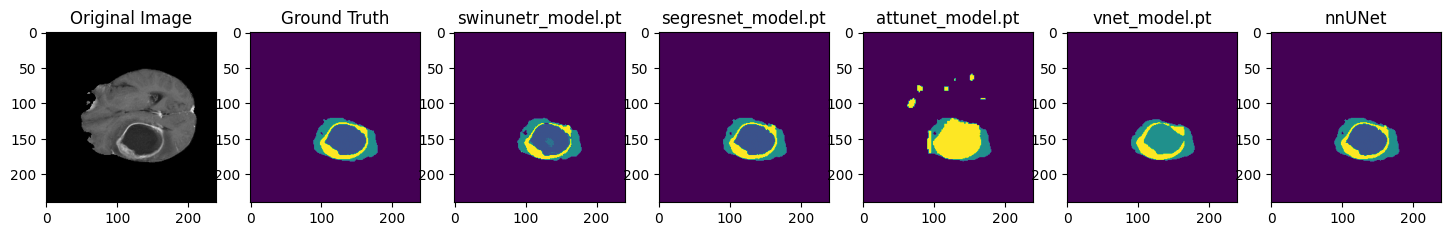

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

models = {
    'swinunetr_model.pt': swinunetr_model,
    'segresnet_model.pt': segresnet_model,
    'attunet_model.pt': attunet_model,
    'vnet_model.pt': vnet_model
}

slice_num = 68
img_add = os.path.join(data_dir, "TrainingData/BraTS2021_" + case_num + "/BraTS2021_" + case_num + "_t1ce.nii.gz")
label_add = os.path.join(data_dir, "TrainingData/BraTS2021_" + case_num + "/BraTS2021_" + case_num + "_seg.nii.gz")
img = nib.load(img_add).get_fdata()
label = nib.load(label_add).get_fdata()

nnunet_segmentation_result = nib.load("/home/agata/Desktop/thesis_tumor_segmentation/nnUNet/nnUNet_results/Dataset101_BraTS2021/BraTS2021_01619.nii.gz").get_fdata()

fig, axs = plt.subplots(1, len(models) + 3, figsize=(18, 6))  
axs[0].imshow(img[:, :, slice_num], cmap="gray")
axs[0].set_title("Original Image")

axs[1].imshow(label[:, :, slice_num])
axs[1].set_title("Ground Truth")

for idx, (model_name, model) in enumerate(models.items()):
    try:
        model.load_state_dict(torch.load(os.path.join(results_dir, model_name))["state_dict"])
        model.to(device)
        model.eval()

        seg_out = get_segmentation(model, roi)

        output_nifti_path = os.path.join(results_dir, f"segmentations/{case_num}_{model_name}_segmentation.nii.gz")
        save_segmentation_as_nifti(seg_out, img_add, output_nifti_path)
        
        axs[idx + 2].imshow(seg_out[:, :, slice_num])
        axs[idx + 2].set_title(f"{model_name}")
        
    except RuntimeError as e:
        print(f"{model_name} failed: {e}")
    finally:
        del model
        torch.cuda.empty_cache()

axs[len(models) + 2].imshow(nnunet_segmentation_result[:, :, slice_num])
axs[len(models) + 2].set_title("nnUNet")

plt.show()

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

training_data_dir = "/home/agata/Desktop/thesis_tumor_segmentation/data/brats2021challenge/TrainingData"
case_folders = [f for f in os.listdir(training_data_dir) if os.path.isdir(os.path.join(training_data_dir, f))]
case_folders = sorted(case_folders)[:100]

for case_folder in case_folders:
    case_num = case_folder.split("_")[-1]  # Extract the case number from the folder name
    
    # Create test_files for each case
    test_files = [{
        "image": [
            os.path.join(training_data_dir, case_folder, f"{case_folder}_flair.nii.gz"),
            os.path.join(training_data_dir, case_folder, f"{case_folder}_t1ce.nii.gz"),
            os.path.join(training_data_dir, case_folder, f"{case_folder}_t1.nii.gz"),
            os.path.join(training_data_dir, case_folder, f"{case_folder}_t2.nii.gz"),
        ],
        "label": os.path.join(training_data_dir, case_folder, f"{case_folder}_seg.nii.gz"),
    }]

    test_transform = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image", "label"]),
        transforms.ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        transforms.NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
    ]
    )

    test_ds = data.Dataset(data=test_files, transform=test_transform)
    test_loader = data.DataLoader(test_ds, batch_size=1, shuffle=False, num_workers=8, pin_memory=True)

    for model_name, model in models.items():
        try:
            model.load_state_dict(torch.load(os.path.join(results_dir, model_name))["state_dict"])
            model.to(device)
            model.eval()

            seg_out = get_segmentation(model, test_loader=test_loader, roi=roi)

            case_folder = create_case_folder(results_dir, case_num)
            output_nifti_path = os.path.join(case_folder, f"BraTS2021_{case_num}_{model_name}_segmentation.nii.gz")
            save_segmentation_as_nifti(seg_out, test_files[0]["image"][1], output_nifti_path)  # Use T1ce as reference

        except RuntimeError as e:
            print(f"{model_name} failed for case {case_num}: {e}")
        finally:
            del model
            torch.cuda.empty_cache()

    print(f"Inference complete for case BraTS2021_{case_num}")



Segmentation saved to /home/agata/Desktop/thesis_tumor_segmentation/results/segmentations/BraTS2021_00000/BraTS2021_00000_swinunetr_model.pt_segmentation.nii.gz
Segmentation saved to /home/agata/Desktop/thesis_tumor_segmentation/results/segmentations/BraTS2021_00000/BraTS2021_00000_segresnet_model.pt_segmentation.nii.gz
Segmentation saved to /home/agata/Desktop/thesis_tumor_segmentation/results/segmentations/BraTS2021_00000/BraTS2021_00000_attunet_model.pt_segmentation.nii.gz
Segmentation saved to /home/agata/Desktop/thesis_tumor_segmentation/results/segmentations/BraTS2021_00000/BraTS2021_00000_vnet_model.pt_segmentation.nii.gz
Inference complete for case BraTS2021_00000
Segmentation saved to /home/agata/Desktop/thesis_tumor_segmentation/results/segmentations/BraTS2021_00002/BraTS2021_00002_swinunetr_model.pt_segmentation.nii.gz
Segmentation saved to /home/agata/Desktop/thesis_tumor_segmentation/results/segmentations/BraTS2021_00002/BraTS2021_00002_segresnet_model.pt_segmentation.nii.

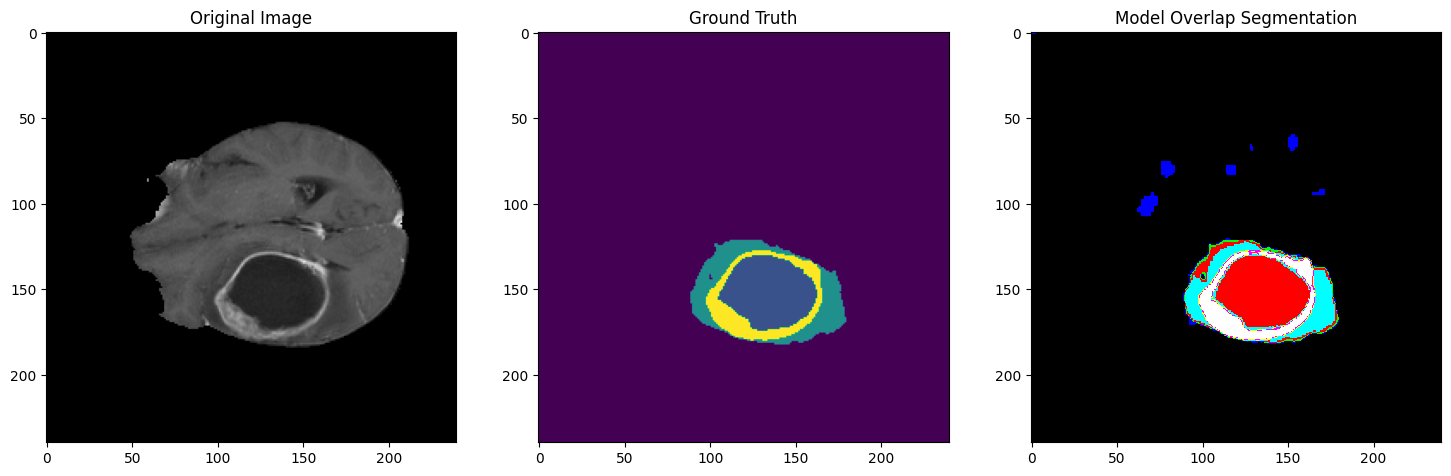

In [8]:
segmentations = {}
segmentations['nnUNet'] = nnunet_segmentation_result

for model_name, model in models.items():
    model.load_state_dict(torch.load(os.path.join(results_dir, model_name))["state_dict"])
    model.to(device)
    model.eval()
    
    seg_out = get_segmentation(model, img, roi)
    segmentations[model_name] = seg_out

overlap_seg = np.zeros_like(next(iter(segmentations.values())))

for model_name, seg in segmentations.items():
    overlap_seg += seg  

colors = [
    [0, 0, 0],          # Background - Black
    [0, 0, 1],          # Single prediction (blue)
    [0, 1, 0],          # Another single prediction (green)
    [1, 0, 0],          # Another single prediction (red)
    [0, 1, 1],          # Overlap of 2 models (cyan)
    [1, 1, 0],          # Overlap of 3 models (yellow)
    [1, 0, 1],          # Overlap of 4 models (magenta)
    [1, 1, 1],          # Overlap of all models (white)
]
cmap = ListedColormap(colors)

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

axs[0].imshow(img[:, :, slice_num], cmap="gray")
axs[0].set_title("Original Image")

axs[1].imshow(label[:, :, slice_num])
axs[1].set_title("Ground Truth")

axs[2].imshow(overlap_seg[:, :, slice_num], cmap=cmap)
axs[2].set_title("Model Overlap Segmentation")

plt.show()

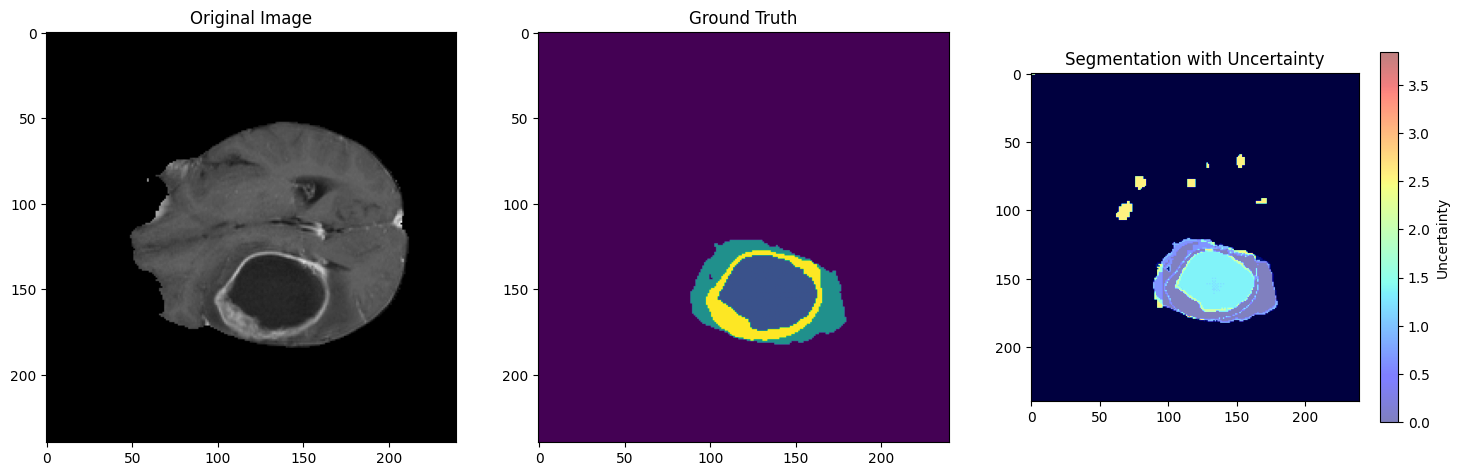

In [10]:
def get_ensemble_segmentation(models, image, roi, test_loader=test_loader, overlap=0.6):
    all_preds = []

    all_preds.append(nnunet_segmentation_result)
    
    for model in models.values():
        seg_out = get_segmentation(model, image, roi, test_loader, overlap)
        all_preds.append(seg_out)

    all_preds = np.array(all_preds)
    mean_preds = np.mean(all_preds, axis=0)
    uncertainty = np.var(all_preds, axis=0)
    final_segmentation = (mean_preds > 0.5).astype(np.int8)
    
    return final_segmentation, uncertainty


def plot_segmentation_with_uncertainty(img, label, segmentation, uncertainty_map, slice_num):
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    axes[0].imshow(img[:, :, slice_num], cmap='gray')
    axes[0].set_title('Original Image')
    
    axes[1].imshow(label[:, :, slice_num])
    axes[1].set_title('Ground Truth')
    
    im = axes[2].imshow(segmentation[:, :, slice_num], cmap='gray')
    
    uncertainty_slice = uncertainty_map[:, :, slice_num]
    im_uncertainty = axes[2].imshow(uncertainty_slice, cmap='jet', alpha=0.5)  
    axes[2].set_title('Segmentation with Uncertainty')
    
    cbar = fig.colorbar(im_uncertainty, ax=axes[2], orientation='vertical', shrink=0.8)
    cbar.set_label('Uncertainty')  
    
    plt.show()

    
segmentation, uncertainty_map = get_ensemble_segmentation(models, img, roi)
plot_segmentation_with_uncertainty(img, label, segmentation, uncertainty_map, slice_num)

Image shape: (79, 95, 79)


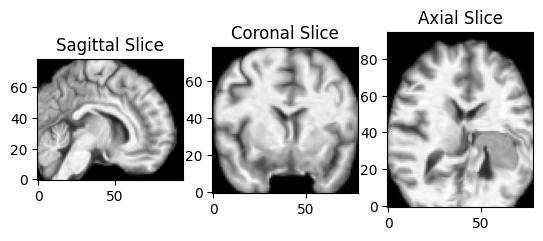

In [2]:
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np

# Load the NIfTI file
nii_file = '/home/agata/Desktop/thesis_tumor_segmentation/data/braintumor_data/ARE/mri/new_ARE_T1.nii'
img = nib.load(nii_file)

# Get the image data as a numpy array
img_data = img.get_fdata()

# Print shape of the image to understand its dimensions (should be 3D)
print("Image shape:", img_data.shape)

# Visualize slices from the middle of the image in each plane (axial, sagittal, coronal)
def show_slices(slices):
    fig, axes = plt.subplots(1, 3)
    axes[0].imshow(slices[0].T, cmap="gray", origin="lower")
    axes[0].set_title("Sagittal Slice")
    axes[1].imshow(slices[1].T, cmap="gray", origin="lower")
    axes[1].set_title("Coronal Slice")
    axes[2].imshow(slices[2].T, cmap="gray", origin="lower")
    axes[2].set_title("Axial Slice")
    plt.show()

# Extract middle slices for each orientation
sagittal_slice = img_data[img_data.shape[0] // 2, :, :]
coronal_slice = img_data[:, img_data.shape[1] // 2, :]
axial_slice = img_data[:, :, img_data.shape[2] // 2]

# Show the slices
show_slices([sagittal_slice, coronal_slice, axial_slice])


In [ ]:
import nibabel as nib 

